In [1]:
%pylab inline
%config InlineBackend.figure_format = 'retina'

Populating the interactive namespace from numpy and matplotlib


In [2]:
import astropy.cosmology as cosmo
from astropy.cosmology import Planck15
import astropy.units as u
import h5py
import pystan
from scipy.interpolate import interp1d
import seaborn as sns

sns.set_context('notebook')
sns.set_style('ticks')
sns.set_palette('colorblind')

In [3]:
model = pystan.StanModel(file='model.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_7055edf431ea3205a5b2aaf01d2476f6 NOW.
/Users/wfarr/anaconda3/lib/python3.6/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /var/folders/35/vcq24mtj2_g5wk96mbck0cw400018s/T/tmpcl92cddj/stanfit4anon_model_7055edf431ea3205a5b2aaf01d2476f6_6300602858672759439.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [4]:
samples = {}
with h5py.File('observations.h5', 'r') as f:
    for k in ['m1det', 'm2det', 'dl']:
        samples[k] = array(f['posteriors'][k])

In [5]:
sel = {}
with h5py.File('selected.h5', 'r') as f:
    sel['m1det'] = array(f['m1det'])
    sel['m2det'] = array(f['m2det'])
    sel['dldet'] = array(f['dl'])
    sel['wtdet'] = array(f['wt'])
    sel['N_gen'] = f.attrs['N_gen']

In [6]:
nobs = 64
nsamp = 16
nsel = 8192

mnorm = exp(arange(log(1), log(200), 0.1))
zinterp = linspace(0, 10, 1000)

bws = []
for i in range(nobs):
    pts = zeros((len(samples['m1det'][0,:]), 3))
    pts[:,0] = samples['m1det'][i,:]
    pts[:,1] = samples['m2det'][i,:]
    pts[:,2] = samples['dl'][i,:]

    c = cov(pts, rowvar=False)
    bws.append(c/nsamp**(2.0/7.0))

data = {
    'nobs': nobs,
    'nsamp': nsamp,
    'nsel': nsel,
    'ninterp': len(zinterp),
    'nnorm': len(mnorm),
    
    'Tobs': 0.5/12.0,
    'N_gen': int(round(sel['N_gen']*float(nsel)/len(sel['m1det']))),
    
    'm1obs': samples['m1det'][:nobs, :nsamp],
    'm2obs': samples['m2det'][:nobs, :nsamp],
    'dlobs': samples['dl'][:nobs, :nsamp],
    
    'bws': bws,
    
    'm1sel': sel['m1det'][:nsel],
    'm2sel': sel['m2det'][:nsel],
    'dlsel': sel['dldet'][:nsel],
    'wtsel': sel['wtdet'][:nsel],
    
    'zinterp': zinterp,
    
    'dl_max': Planck15.luminosity_distance(zinterp[-1]).to(u.Gpc).value,
    
    'ms_norm': mnorm,
    
    'use_cosmo_prior': 0,
    'mu_H0': 70.,
    'sigma_H0': 15.0,
    'mu_Omh2': 0.3*0.7**2,
    'sigma_Omh2': 0.1*0.3*0.7**2
}

In [7]:
def draw_init():
    i = {}
    
    i['H0'] = 70 + 5*randn()
    i['Om'] = 0.3 + 0.05*randn()
    i['w'] = -1.0 + 0.1*randn()
    
    c = cosmo.FlatwCDM(i['H0']*u.km/u.s/u.Mpc, i['Om'], i['w'])
    
    zs = linspace(0, 10, 1000)
    ds = c.luminosity_distance(zs).to(u.Gpc).value
    
    z_of_d = interp1d(ds, zs)
    
    i['R0'] = 100.0 + 5*randn()
    i['MMin'] = 5 + rand()
    i['MMax'] = 40 + 3*randn()
    
    i['alpha'] = -0.75 + 0.1*randn()
    i['beta'] = 0.0 + 0.1*randn()
    i['gamma'] = 3 + 0.1*randn()
    
    i['sigma_low'] = 0.1 + 0.01*randn()
    i['sigma_high'] = 0.1 + 0.01*randn()
    
    zsamples = z_of_d(samples['dl'])
    
    isamp = random.randint(samples['m1det'].shape[1])
    
    i['m1s'] = samples['m1det'][:nobs, isamp]/(1+zsamples[:nobs, isamp])
    m2s = samples['m2det'][:nobs, isamp]/(1+zsamples[:nobs, isamp])
    i['dls'] = samples['dl'][:nobs, isamp]/(1+zsamples[:nobs, isamp])
    i['m2_frac'] = (m2s - 3.0)/(i['m1s'] - 3.0)
    
    return i

In [8]:
p = model.sampling(iter=20, data=data, init=[draw_init() for i in range(4)])

/Users/wfarr/anaconda3/lib/python3.6/site-packages/pystan/misc.py:356: RuntimeWarning: invalid value encountered in sqrt
  sem=msd[:, 1] / np.sqrt(ess), ess=ess, rhat=rhat,


In [9]:
p


For the full summary use 'print(fit)'

Inference for Stan model: anon_model_7055edf431ea3205a5b2aaf01d2476f6.
4 chains, each with iter=20; warmup=10; thin=1; 
post-warmup draws per chain=10, total post-warmup draws=40.

              mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
H0           61.53   11.36  20.73  24.57  42.76  65.35  79.11  96.72      3   1.84
Om             0.3    0.04   0.13   0.02   0.22    0.3   0.42   0.51     13   1.12
w            -1.32    0.08   0.44  -2.45  -1.56  -1.22  -1.03  -0.56     33   1.06
R0            98.8    7.27  35.07  47.54  73.51  96.26 113.18 189.79     23   1.15
MMin          5.16    0.19   0.98   3.35   4.27   5.34   6.06   6.57     28    1.0
MMax         44.38    4.56   8.21  32.87  37.71  42.09   50.4  62.36      3   2.44
alpha         0.81    0.14   0.43  -0.06    0.5    0.8   1.12   1.65     10    1.1
beta         -0.04    0.15    0.6  -0.95  -0.51  -0.05   0.19   1.44     15   1.15
gamma         3.17    0.76   1.2

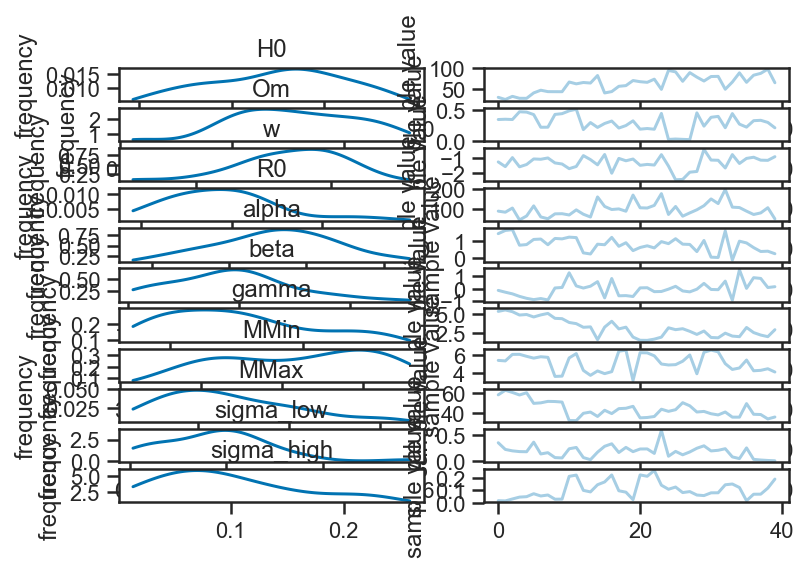

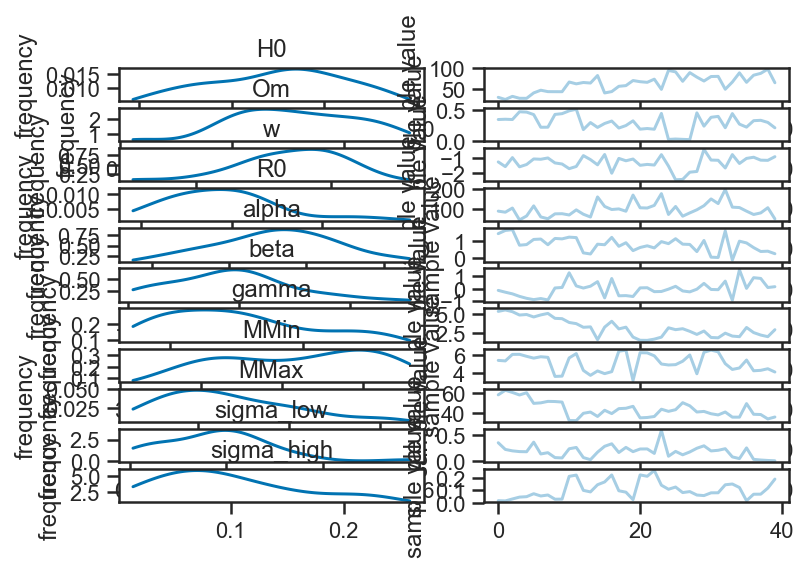

In [10]:
p.plot(['H0', 'Om', 'w', 'R0', 'alpha', 'beta', 'gamma', 'MMin', 'MMax', 'sigma_low', 'sigma_high'])

In [11]:
c = p.extract(permuted=True)

In [12]:
cosm = cosmo.FlatwCDM(c['H0'][0], c['Om'][0], c['w'][0])

In [13]:
cosm.luminosity_distance(c['zs'][0,1]).to(u.Gpc).value

5.172742030681527

In [14]:
c['dls'][0,1]

5.172818499133546